<a href="https://colab.research.google.com/github/TasneemBadry/TasneemBadry/blob/main/speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Deep learning based end-to-end speech recognition

The goal of this assignment is to get familiar with applications that require speech data as input.

We would be using the torchaudio library (pip install torchaudio==0.11.0), please carefull read this tutorial https://pytorch.org/tutorials/intermediate/speech_recognition_pipeline_tutorial.html

Next, we would ask you to perform similar analysis on a speech dataset, i.e., speechdata.zip. Unzip this folder, you would see a folder named wavs, and a file called "labels.csv", containing annotated transcripts, including the files in the wavs folder (you have more labels in labels.csv). This dataset is selected from https://keithito.com/LJ-Speech-Dataset/, a famous speech-based application benchmark.

General torchaudio tutorials: https://pytorch.org/tutorials/index.html

**Submission: submit via onq.**


In [ ]:
# Import needed libraries.
import IPython
import matplotlib
import requests
import torch
import torchaudio

import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

%matplotlib inline

## Task 1: Basic data exploration
Select one randomly sampled wav file in the given folder, perform the following analysis:

1) Print the shape of the picked waveform

2) Print the sample rate of the waveform.

3) Visualize the waveform using matplotlib

4) Create the spectrogram representation of the picked waveform and visualize it.

5) Create the MFCC representation of the picked waveform and visualize it.

Reference: https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration/notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# TODO code for task 1
SPEECH_FILE= "/content/drive/MyDrive/wavs/LJ001-0001.wav"

waveform, sample_rate = torchaudio.load(SPEECH_FILE)


print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

Shape of waveform: torch.Size([1, 212893])
Sample rate of waveform: 22050


In [ ]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

In [ ]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

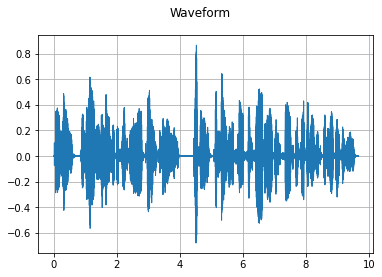

In [ ]:
plot_waveform(waveform, sample_rate)

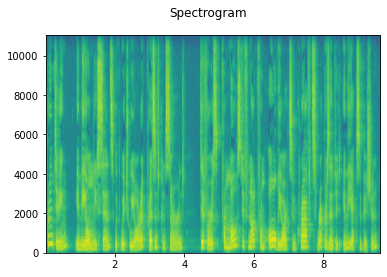

In [ ]:
plot_specgram(waveform, sample_rate)

In [ ]:
ipd.Audio(SPEECH_FILE)

In [ ]:
# from sys import path
path='/content/drive/MyDrive/wavs/'
name='/LJ001-0001.wav'
samples = wavfile.read(str(path) + name)


In [ ]:
waveform_array = waveform.numpy()

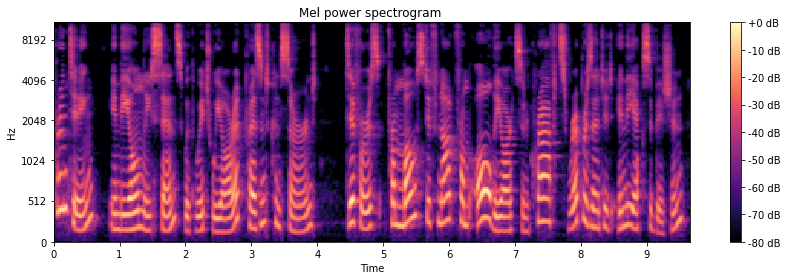

In [ ]:
S = librosa.feature.melspectrogram(waveform_array[0], sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

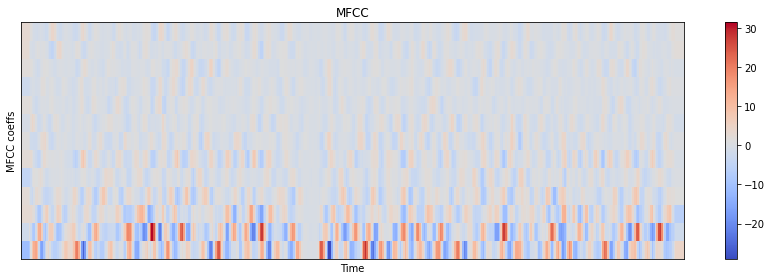

In [ ]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

## Task 2: Creating a Wav2Vec2 model that can perform feature extraction and classification.


In [ ]:
# TODO code for task 2
# Build the model and load pretrained weights
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print("Sample Rate:", bundle.sample_rate)

model = bundle.get_model()
# print('\nModel Architecture')
# print(model)

labels = bundle.get_labels()
print('\nlabels: ', labels)

# Resample audio to the expected sampling rate
if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

# Wav2Vec2 model provides method to perform the feature extraction and classification in one step
# Infer the label probability distribution
emissions, _ = model(waveform)

print('\nemissions ', emissions)

Sample Rate: 16000

labels:  ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')

emissions  tensor([[[ 14.9316,   1.2051,   0.3590,  ...,  -8.9404,  -6.4388, -13.4237],
         [  3.4015,  -0.8861,   0.9520,  ...,  -6.8746,  -2.5634, -10.5984],
         [ 10.5939,  -1.3360,  -2.7532,  ...,  -9.4607, -10.2677, -10.2694],
         ...,
         [ 14.7813,  -1.3944,  -3.2578,  ...,  -6.7257,  -7.6747,  -9.2240],
         [ 14.7899,  -1.3682,  -3.2692,  ...,  -6.7286,  -7.6794,  -9.2264],
         [ 14.7048,  -0.5374,  -1.8725,  ...,  -7.6599,  -8.4477,  -8.7742]]],
       grad_fn=<AddBackward0>)


In [ ]:
with torch.inference_mode():
    emission, _ = model(waveform)

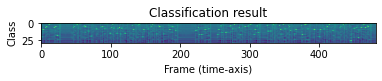

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

## Task 3: Extract acoustic features and generate predicted transcript for each waveform in the given dataset

In [ ]:
# TODO code for task 3
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

In [ ]:
# waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

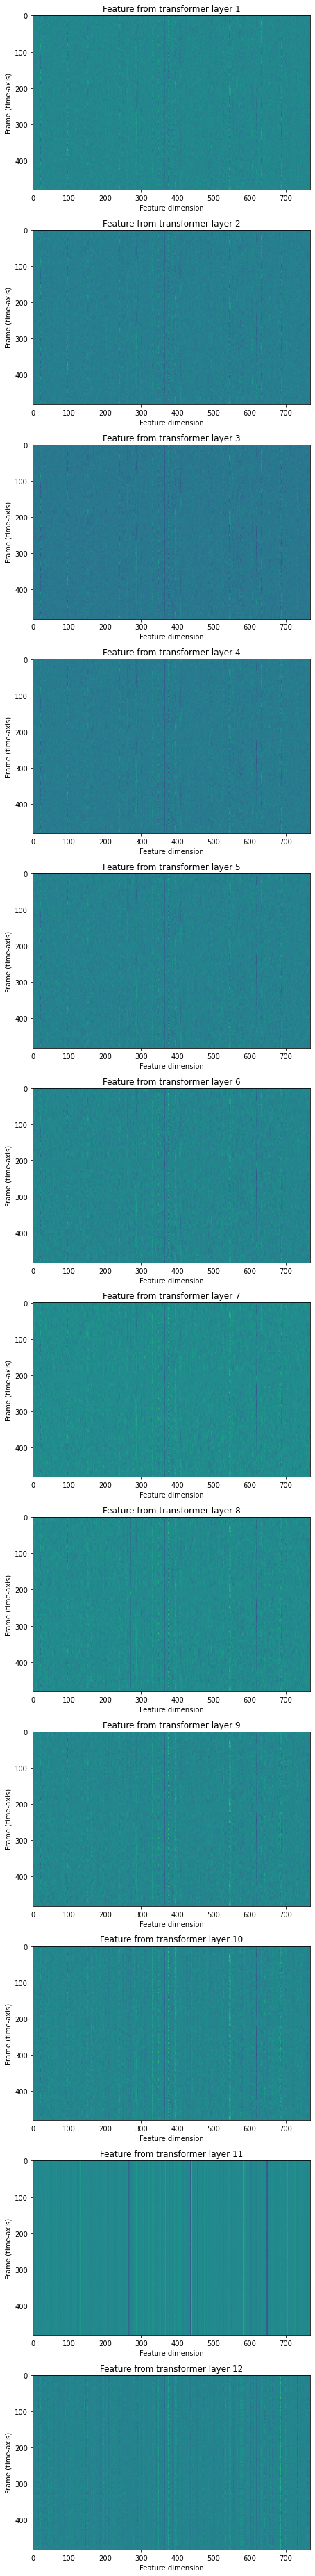

In [ ]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu())
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [ ]:
# Generating transcripts
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        print('Predict a sequence of tokens', indices)
        indices = torch.unique_consecutive(indices, dim=-1)
        print('\nMerge repeats ', indices)
        # Final output after dropping blank (-)
        indices = [i for i in indices if i != self.blank]
        print('\nlabels', [self.labels[i] for i in indices])
        return "".join([self.labels[i] for i in indices])

In [ ]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emissions[0])

print('\nTranscript:', transcript)

Predict a sequence of tokens tensor([ 0, 20, 10, 10,  0,  0,  7,  6,  6,  0,  0,  3,  3,  0,  0,  0,  0,  0,
         7,  7,  6,  6,  0, 18,  0,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  6,  0,  1,  1,  3,  3,  8,
         2,  2,  1,  1,  0,  0,  0,  0,  5,  0,  6,  0,  0,  0, 12,  0,  0,  0,
        19,  1,  1,  1,  0,  0,  0,  9,  9,  0,  0,  0,  0,  2,  2,  6,  6,  0,
         0,  9,  9,  2,  1,  1,  1,  0,  0, 15,  0,  7,  0,  3,  8,  8,  1,  0,
         0, 15,  8,  8,  7,  7, 16,  8,  8,  1,  1,  0, 15, 15,  0,  0,  2,  0,
         1,  1,  0,  0,  0,  4,  0, 10,  0,  2,  1,  1,  0,  4,  3,  3,  1,  1,
         0,  0, 20, 10, 10,  0,  0,  2,  0,  0,  9,  0,  0,  2,  6,  0,  3,  0,
         1,  1,  0,  0, 16,  0,  0,  5,  6,  6,  0,  0,  0,  0, 16,  0,  0,  0,
         0,  0,  0,  2,  0, 10,  0,  0,  6,  6,  0,  0,  2, 11,  0,  1,  1,  1,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,

In [ ]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

PRINTING|IN|THE|ONLY|SENSE|WITH|WHICH|WE|ARE|AT|PRESENT|CONCERNED|DIFFERS|FROM|MOST|IF|NOT|FROM|ALL|THE|ARTS|AND|CRAFTS|REPRESENTED|IN|THE|EXHIBITION|


In [ ]:
# from scipy.signal import waveforms
import glob

waveforms=[]
files_name=[]
sample_rates=[]
files = glob.glob(f"/content/drive/MyDrive/wavs/*.wav")
for file in files:
    files_name.append(file)
    # with open(os.path.join(os.getcwd(), file), 'r') as f:
    waveform, sample_rate = torchaudio.load(file)
    waveforms.append(waveform)
    sample_rates.append(sample_rate)
    IPython.display.Audio(file)
    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))

Shape of waveform: torch.Size([1, 156317])
Sample rate of waveform: 22050
Shape of waveform: torch.Size([1, 154781])
Sample rate of waveform: 22050
Shape of waveform: torch.Size([1, 99485])
Sample rate of waveform: 22050
Shape of waveform: torch.Size([1, 118429])
Sample rate of waveform: 22050
Shape of waveform: torch.Size([1, 97437])
Sample rate of waveform: 22050
Shape of waveform: torch.Size([1, 170141])
Sample rate of waveform: 22050
Shape of waveform: torch.Size([1, 191133])
Sample rate of waveform: 22050
Shape of waveform: torch.Size([1, 181661])
Sample rate of waveform: 22050
Shape of waveform: torch.Size([1, 150173])
Sample rate of waveform: 22050
Shape of waveform: torch.Size([1, 181661])
Sample rate of waveform: 22050
Shape of waveform: torch.Size([1, 122781])
Sample rate of waveform: 22050
Shape of waveform: torch.Size([1, 149405])
Sample rate of waveform: 22050
Shape of waveform: torch.Size([1, 173213])
Sample rate of waveform: 22050
Shape of waveform: torch.Size([1, 107165

## Task 4: evaluate the performance of the trained model on the testing dataset using Word Error Rate (WER), Match Error Rate (MER)

Hint: consider this package, https://pypi.org/project/jiwer/

In [ ]:
file=pd.read_csv('/content/drive/MyDrive/labels.csv',sep='|', names = ['file_name', 'text1', 'text2'])
file

,file_name,text1,text2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,"in being comparatively modern.,,,,,,,,,,,,,,,,,,,"
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
...,...,...,...
518,LJ002-0334,"Again, there was no regular allowance of fuel....","Again, there was no regular allowance of fuel...."
519,LJ002-0335,"so were candles, salt, pepper, mops and brooms...","so were candles, salt, pepper, mops and brooms..."
520,LJ002-0336,"indeed the place, with its oak floors caulked ...","indeed the place, with its oak floors caulked ..."
521,LJ002-0337,could not be made even to look clean while the...,could not be made even to look clean while the...


In [ ]:
# TODO code for task 4
# Word Error Rate (WER)
!pip install jiwer
from jiwer import wer
import jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import pickle
import sklearn
import pandas as pd
import numpy as np
import holoviews as hv
import nltk
from bokeh.io import output_notebook
output_notebook()

from pathlib import Path
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))


def clean_text(text, for_embedding=False):

    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# %%time
# # Clean Comments
# file["txt1_clean"] = file.loc[file['text1'].str.len() > 0, 'text1']
# file["txt1_clean"] = file["txt1_clean"].map(
#     lambda x: clean_text(x, for_embedding=False) if isinstance(x, str) else x
# )

In [ ]:
# %%time
# # Clean Comments
# file["txt2_clean"] = file.loc[file['text2'].str.len() > 0, 'text2']
# file["txt2_clean"] = file["txt2_clean"].map(
#     lambda x: clean_text(x, for_embedding=False) if isinstance(x, str) else x
# )

In [ ]:
file

,file_name,text1,text2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,"in being comparatively modern.,,,,,,,,,,,,,,,,,,,"
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
...,...,...,...
518,LJ002-0334,"Again, there was no regular allowance of fuel....","Again, there was no regular allowance of fuel...."
519,LJ002-0335,"so were candles, salt, pepper, mops and brooms...","so were candles, salt, pepper, mops and brooms..."
520,LJ002-0336,"indeed the place, with its oak floors caulked ...","indeed the place, with its oak floors caulked ..."
521,LJ002-0337,could not be made even to look clean while the...,could not be made even to look clean while the...


In [ ]:
# transformation = jiwer.Compose([
#     jiwer.ToLowerCase(),
#     jiwer.RemoveWhiteSpace(replace_by_space=True),
#     jiwer.RemoveMultipleSpaces(),
#     jiwer.RemovePunctuation()])

In [ ]:
for i in range(0, 100):
    # print(df.loc[i].text2)
    file.loc[i, 'ground_truth'] = clean_text(file.loc[i].text2) # apply function on text2 data
    file.loc[i, 'hypothesis'] = clean_text(file.loc[i].text1) # apply function on transcript data

    file.loc[i, 'wer'] = jiwer.wer(file.loc[i].ground_truth, file.loc[i].hypothesis)
    file.loc[i, 'mer'] = jiwer.mer(file.loc[i].ground_truth, file.loc[i].hypothesis)

## Task 5: check files with the worst performance and perform a simple error analysis, e.g., what are the files having worser performance, and what are the potential reasons, do they share any common patterns?


In [ ]:
# TODO code for task 5
file.sort_values(by=['wer'], ascending=False).head()

,file_name,text1,text2,ground_truth,hypothesis,wer,mer
44,LJ001-0045,"1469, 1470;","fourteen sixty-nine, fourteen seventy;",fourte sixty nin fourte seventy,,1.000000,1.000000
30,LJ001-0031,In 1465 Sweynheim and Pannartz began printing ...,In fourteen sixty-five Sweynheim and Pannartz ...,fourte sixty fiv sweynheim and pannartz began ...,sweynheim and pannartz began printing the mona...,0.214286,0.214286
23,LJ001-0024,But the first Bible actually dated (which also...,But the first Bible actually dated (which also...,but the first bibl actually dated which printe...,but the first bibl actually dated which printe...,0.166667,0.166667
91,LJ001-0092,The Chiswick press in 1844 revived Caslon's fo...,The Chiswick press in eighteen forty-four revi...,the chiswick press eighte forty four revived c...,the chiswick press revived caslon fount printi...,0.166667,0.166667
6,LJ001-0007,"the earliest book printed with movable types, ...","the earliest book printed with movable types, ...",the earli book printed with movabl typ the gut...,the earli book printed with movabl typ the gut...,0.157895,0.157895


In [ ]:
file.sort_values(by=['mer'], ascending=False).head()

,file_name,text1,text2,ground_truth,hypothesis,wer,mer
44,LJ001-0045,"1469, 1470;","fourteen sixty-nine, fourteen seventy;",fourte sixty nin fourte seventy,,1.000000,1.000000
30,LJ001-0031,In 1465 Sweynheim and Pannartz began printing ...,In fourteen sixty-five Sweynheim and Pannartz ...,fourte sixty fiv sweynheim and pannartz began ...,sweynheim and pannartz began printing the mona...,0.214286,0.214286
23,LJ001-0024,But the first Bible actually dated (which also...,But the first Bible actually dated (which also...,but the first bibl actually dated which printe...,but the first bibl actually dated which printe...,0.166667,0.166667
91,LJ001-0092,The Chiswick press in 1844 revived Caslon's fo...,The Chiswick press in eighteen forty-four revi...,the chiswick press eighte forty four revived c...,the chiswick press revived caslon fount printi...,0.166667,0.166667
6,LJ001-0007,"the earliest book printed with movable types, ...","the earliest book printed with movable types, ...",the earli book printed with movabl typ the gut...,the earli book printed with movabl typ the gut...,0.157895,0.157895


In [ ]:
print(list(file[file['file_name'] =='LJ001-0024'].ground_truth))

['but the first bibl actually dated which printed at maintz by pet schoeff the year fourte sixty two']


In [ ]:
print(list(file[file['file_name'] =='LJ001-0024'].hypothesis))

['but the first bibl actually dated which printed at maintz by pet schoeff the year']


the audio which have a big value of wer and mer, this is the worst performance.       
the audio(LJ001-0045) is the worst performance  